Submitted by:
Tohar Brenner: 307940361
Yuval Levi: 305730897
Hadar Verthaim: 026554253


Import packages

In [39]:
import numpy as np
import pandas as pd
import math
from math import sqrt
import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns
import pickle
import os
from tqdm import tqdm
from sklearn.metrics import mean_squared_error
from pylab import rcParams
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import register_matplotlib_converters

from torch import nn as nn, optim as optim, functional as F
from datetime import datetime

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import random_split
from torch.utils.data import DataLoader
import torchvision
from torchvision.utils import make_grid
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torchvision import models
from torchsummary import summary

from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.stattools import pacf
from statsmodels.regression.linear_model import yule_walker
from statsmodels.tsa.stattools import adfuller

%matplotlib inline



# Question 1


`Initialize variables `

In [2]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [5]:
max_epochs = 10
batch_size = 128
learning_rate = 1e-4

torch.manual_seed(43)

`Prepare the dataset`


In [6]:
dataset = CIFAR10(root='data/', download=True, transform=transforms.ToTensor())
test_dataset = CIFAR10(root='data/', train=False, transform=transforms.ToTensor())
val_size = 5000
train_size = len(dataset) - val_size

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data/


In [7]:
train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(45000, 5000)

In [8]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size*2, num_workers=2, pin_memory=True)

images.shape: torch.Size([128, 3, 32, 32])


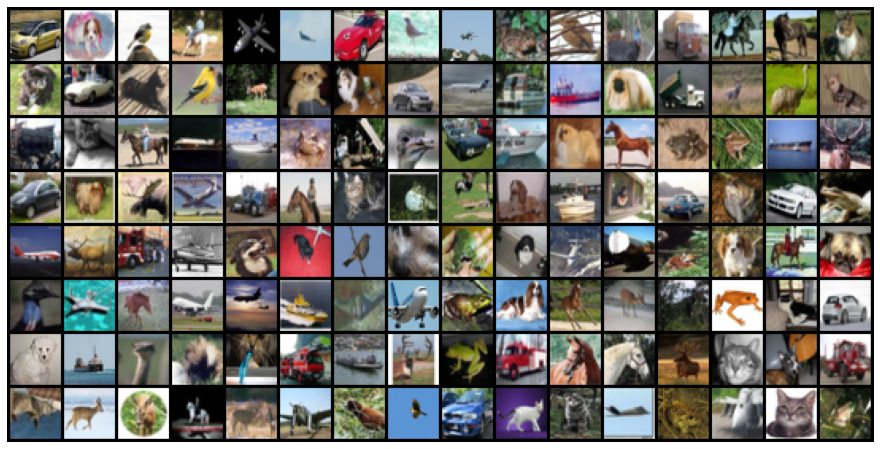

In [9]:
for images, _ in train_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

In [10]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [11]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [12]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [13]:
def plot_losses(history):
    losses = [x['val_loss'] for x in history]
    plt.plot(losses, '-x')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Loss vs. No. of epochs');

In [14]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

In [15]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [16]:
device = get_default_device()
device

device(type='cpu')

In [17]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [18]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

In [19]:
class FC(ImageClassificationBase):
  def __init__(self):
      # the order of the layers accorgind to https://arxiv.org/pdf/1502.03167.pdf
      super().__init__()
      self.layers = nn.Sequential(
      nn.Flatten(),
      nn.Linear(32 * 32 * 3, 64),
      nn.BatchNorm1d(64),
      nn.ReLU(),
      nn.Dropout(0.2),
      nn.Linear(64, 10))
    
  def forward(self, x):
    return self.layers(x)

In [20]:
class CNN(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16
            nn.BatchNorm2d(64),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8
            nn.BatchNorm2d(128),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4
            nn.BatchNorm2d(256),

            nn.Flatten(), 
            nn.Linear(256*4*4, 1024),
            nn.Dropout(0.2),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.Dropout(0.2), 
            nn.ReLU(),
            nn.Linear(512, 10))
        
    def forward(self, x):
      return self.layers(x)

In [21]:
model_FC = to_device(FC(), device)

In [22]:
model_CNN = to_device(CNN(), device)

*Fully connected layers only (1D) with batchnorm and dropout*

In [23]:
history_fc = [evaluate(model_FC, val_loader)]
history_fc

[{'val_acc': 0.09508272260427475, 'val_loss': 2.3989462852478027}]

In [24]:
history_fc += fit(max_epochs, learning_rate, model_FC, train_loader, val_loader)

Epoch [0], val_loss: 2.2661, val_acc: 0.1454
Epoch [1], val_loss: 2.1964, val_acc: 0.1939
Epoch [2], val_loss: 2.1597, val_acc: 0.2206
Epoch [3], val_loss: 2.1257, val_acc: 0.2377
Epoch [4], val_loss: 2.1082, val_acc: 0.2451
Epoch [5], val_loss: 2.0843, val_acc: 0.2613
Epoch [6], val_loss: 2.0665, val_acc: 0.2774
Epoch [7], val_loss: 2.0502, val_acc: 0.2766
Epoch [8], val_loss: 2.0340, val_acc: 0.2935
Epoch [9], val_loss: 2.0253, val_acc: 0.2899


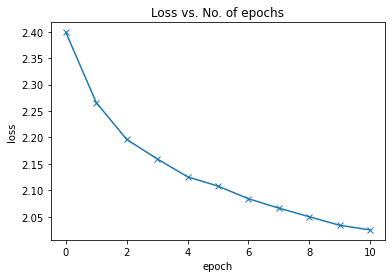

In [25]:
plot_losses(history_fc)

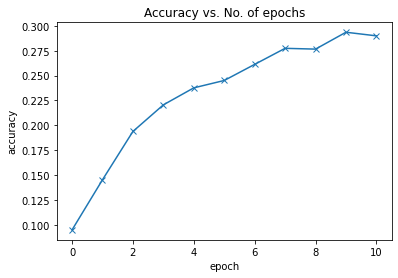

In [26]:
plot_accuracies(history_fc)

In [27]:
evaluate(model_FC, test_loader)

{'val_acc': 0.3072265684604645, 'val_loss': 2.0085740089416504}

*Combining convolution layers and fully connected layers (2D) with batchnorm and dropout*

In [28]:
history_cnn = [evaluate(model_CNN, val_loader)]
history_cnn

[{'val_acc': 0.0966796875, 'val_loss': 2.315037250518799}]

In [29]:
history_cnn += fit(max_epochs, learning_rate, model_CNN, train_loader, val_loader)

Epoch [0], val_loss: 2.2961, val_acc: 0.1157
Epoch [1], val_loss: 2.2800, val_acc: 0.1578
Epoch [2], val_loss: 2.2626, val_acc: 0.1817
Epoch [3], val_loss: 2.2444, val_acc: 0.2002
Epoch [4], val_loss: 2.2282, val_acc: 0.2167
Epoch [5], val_loss: 2.2098, val_acc: 0.2344
Epoch [6], val_loss: 2.1908, val_acc: 0.2501
Epoch [7], val_loss: 2.1700, val_acc: 0.2550
Epoch [8], val_loss: 2.1474, val_acc: 0.2718
Epoch [9], val_loss: 2.1266, val_acc: 0.2774


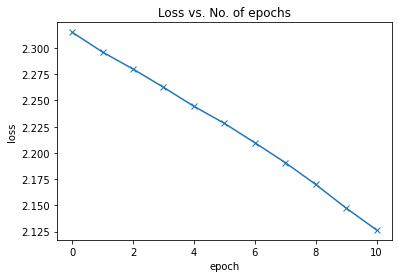

In [30]:
plot_losses(history_cnn)

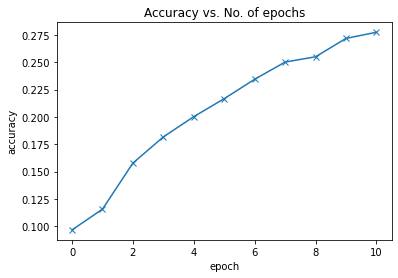

In [31]:
plot_accuracies(history_cnn)

In [32]:
evaluate(model_CNN, test_loader)

{'val_acc': 0.2860351502895355, 'val_loss': 2.1168899536132812}

`Before learning, the performance of a fully connected network was the accuracy of 0.1057 and loss of 2.366. After learning, when the number of epochs is 10, and the batch size is 128, the accuracy is 0.288, and the loss value is 2.0278. For the same hyper-parameters (epochs and batch size) before training, the convolution network measures were 0.097 accuracies and 2.311 for the loss function. After learning, the accuracy is 0.2659, and the loss is 2.21246. As we can see, the convolution net successfully learns better than the FC net for this dataset.`

# Question 2

In [36]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? n
Nothing done.


```
1. rgnp : Real GNP.
2. pgnp : Potential real GNP.
3. ulc : Unit labor cost.
4. gdfco : Fixed weight deflator for personal consumption expenditure excluding food and energy.
5. gdf : Fixed weight GNP deflator.
6. gdfim : Fixed weight import deflator.
7. gdfcf : Fixed weight deflator for food in personal consumption expenditure.
8. gdfce : Fixed weight deflator for energy in personal consumption expenditure.
```



In [40]:
num_observ = 10 # the number of observations to predict

In [41]:
filepath = 'https://raw.githubusercontent.com/selva86/datasets/master/Raotbl6.csv'
df = pd.read_csv(filepath, parse_dates=['date'], index_col='date')
print(df.shape)  # (123, 8)
df.head()

(123, 8)


,rgnp,pgnp,ulc,gdfco,gdf,gdfim,gdfcf,gdfce
date,,,,,,,,
1959-01-01,1606.4,1608.3,47.5,36.9,37.4,26.9,32.3,23.1
1959-04-01,1637.0,1622.2,47.5,37.4,37.5,27.0,32.2,23.4
1959-07-01,1629.5,1636.2,48.7,37.6,37.6,27.1,32.4,23.4
1959-10-01,1643.4,1650.3,48.8,37.7,37.8,27.1,32.5,23.8
1960-01-01,1671.6,1664.6,49.1,37.8,37.8,27.2,32.4,23.8


In [42]:
df.tail()

,rgnp,pgnp,ulc,gdfco,gdf,gdfim,gdfcf,gdfce
date,,,,,,,,
1988-07-01,4042.7,3971.9,179.6,131.5,124.9,106.2,123.5,92.8
1988-10-01,4069.4,3995.8,181.3,133.3,126.2,107.3,124.9,92.9
1989-01-01,4106.8,4019.9,184.1,134.8,127.7,109.5,126.6,94.0
1989-04-01,4132.5,4044.1,186.1,134.8,129.3,111.1,129.0,100.6
1989-07-01,4162.9,4068.4,187.4,137.2,130.2,109.8,129.9,98.2


In [43]:
test = 'ssr_chi2test'
test_result = grangercausalitytests(df[['rgnp','pgnp']], maxlag=10, verbose=False)
p_values = [round(test_result[i+1][0][test][1],4) for i in range(10)]
print('p_values = ',p_values)
print('min_p_value = ',np.min(p_values))

p_values =  [0.3256, 0.1849, 0.111, 0.2159, 0.2772, 0.0106, 0.0152, 0.0126, 0.0211, 0.0401]
min_p_value =  0.0106


In [44]:
r = adfuller(df['rgnp'], autolag='AIC')
output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
p_value = output['pvalue'] 
print(output)

{'test_statistic': 0.6419, 'pvalue': 0.9886, 'n_lags': 2, 'n_obs': 120}


In [45]:
v = df.rgnp.values
dv = np.diff(v)
r = adfuller(dv, autolag='AIC')
output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
p_value = output['pvalue'] 
print(output)

{'test_statistic': -5.4276, 'pvalue': 0.0, 'n_lags': 1, 'n_obs': 120}


In [46]:
def adfuller_test(series, sig=0.05, name=''):
    res = adfuller(series, autolag='AIC')    
    p_value = round(res[1], 3) 

    if p_value <= sig:
        print(f" {name} : P-Value = {p_value} => Stationary. ")
    else:
        print(f" {name} : P-Value = {p_value} => Non-stationary.")

*Section 1 - AR (autoregressive) Model*


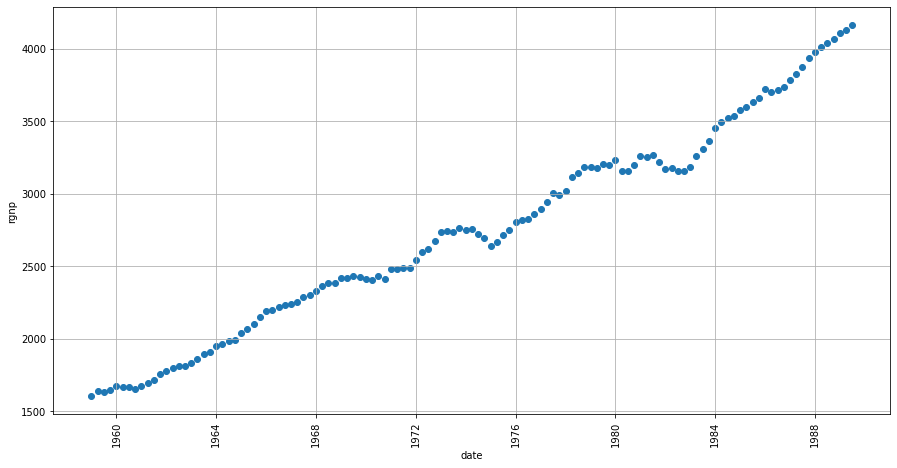

In [47]:
plt.figure(figsize=[15, 7.5]); # Set dimensions for figure
plt.scatter(df.reset_index()['date'], df['rgnp'])
plt.title('')
plt.ylabel('rgnp')
plt.xlabel('date')
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

In [48]:
# Dicker-Fuller test for check the feature stationary or not
adfuller_test(df['rgnp'])

  : P-Value = 0.989 => Non-stationary.


In [49]:
# calculates the difference of element compared with element in previous row
df = df.diff().dropna()

In [50]:
adfuller_test(df['rgnp'])

  : P-Value = 0.0 => Stationary. 


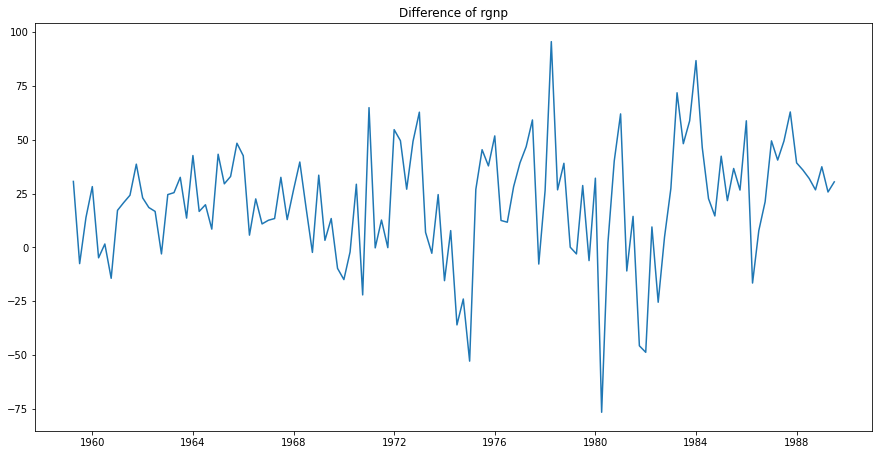

In [51]:
plt.figure(figsize=[15, 7.5]); 
plt.plot(df['rgnp'])
plt.title("Difference of rgnp")
plt.show()

In [52]:
df_train = df[1:len(df['rgnp'])-num_observ]
df_test = df[len(df['rgnp'])-num_observ:]

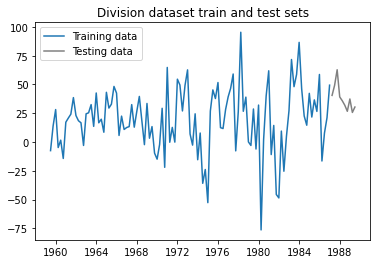

In [53]:
plt.title('Division dataset train and test sets')
plt.plot(df_train['rgnp'], label='Training data')
plt.plot(df_test['rgnp'], color='gray', label='Testing data')
plt.legend();

In [54]:
def train_and_plot(maxlag):
    model = AR(df_train['rgnp']).fit(maxlag=maxlag, method='mle')
    forecasts = model.predict(start=len(df_train), end=len(df_train) + len(df_test) - 1, dynamic=False)
    parameters = model.params.to_dict()
    for k, v in parameters.items():
        parameters[k] = np.round(v, 3)
    plt.title(f'AR({maxlag}) training/testing data and forecasts', size=20, y=1.1)
    plt.suptitle(parameters, y=0.94)
    plt.plot(df_train['rgnp'], label='Training data')
    plt.plot(df_test['rgnp'], color='gray', label='Testing data')
    plt.plot(forecasts, color='orange', label='Forecasts')
    plt.legend();

In [55]:
max_p = 10
errors = {}

for p in range(1, max_p + 1):
    model = AR(df_train['rgnp']).fit(maxlag=p, dynamic=False)
    preds = model.predict(start=len(df_train), end=len(df_train) + len(df_test) - 1, dynamic=False)
    error = mean_squared_error(df_test['rgnp'], preds, squared=False)
    errors[f'AR({p})'] = error
print(errors)

{'AR(1)': 19.998542818116675, 'AR(2)': 18.843096009873957, 'AR(3)': 19.327950055069955, 'AR(4)': 19.16774510507466, 'AR(5)': 19.126841746176666, 'AR(6)': 18.856322424293595, 'AR(7)': 19.441646077785954, 'AR(8)': 21.133637817028678, 'AR(9)': 21.31224039114322, 'AR(10)': 21.174625893215552}


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  % freq, ValueWarning)
/usr/local

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  % freq, ValueWarning)


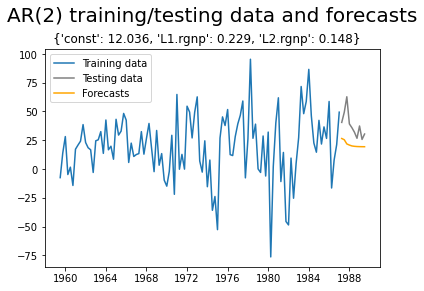

In [56]:
train_and_plot(maxlag=2)

*Section 2 - VAR (vector autoregressive) Model*

In [57]:
num_observ = 10 # the number of observations to predict

filepath = 'https://raw.githubusercontent.com/selva86/datasets/master/Raotbl6.csv'
df = pd.read_csv(filepath, parse_dates=['date'], index_col='date')

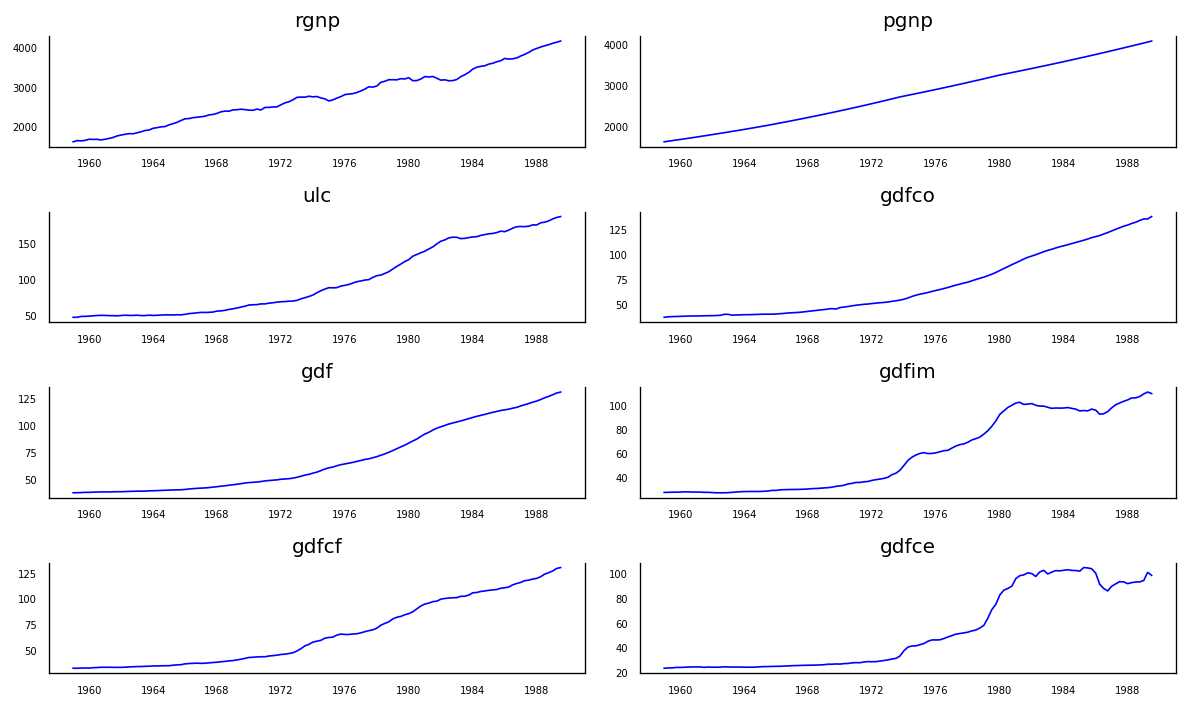

In [58]:
fig, axes = plt.subplots(nrows=4, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = df[df.columns[i]]
    ax.plot(data, color='blue', linewidth=1)
    # Decorations
    ax.set_title(df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

```
Testing Causation using Granger’s Causality Test
```



In [59]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(df, variables = df.columns)  

,rgnp_x,pgnp_x,ulc_x,gdfco_x,gdf_x,gdfim_x,gdfcf_x,gdfce_x
rgnp_y,1.0000,0.0003,0.0001,0.0212,0.0014,0.0620,0.0001,0.0071
pgnp_y,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
ulc_y,0.0000,0.0000,1.0000,0.0002,0.0000,0.0000,0.0000,0.0041
gdfco_y,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000
gdf_y,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000
gdfim_y,0.0011,0.0067,0.0014,0.0083,0.0011,1.0000,0.0004,0.0000
gdfcf_y,0.0000,0.0000,0.0008,0.0008,0.0000,0.0038,1.0000,0.0009
gdfce_y,0.0025,0.0485,0.0000,0.0002,0.0000,0.0000,0.0000,1.0000


`Looking at the P-Values in the above table, we can pretty much observe that all the variables (time series) in the system are interchangeably causing each other. This makes this system of multi-time series a good candidate for using VAR models to forecast. `

In [60]:
df_train = df[1:len(df['rgnp'])-num_observ]
df_test = df[len(df['rgnp'])-num_observ:]

`Check for stationarity for evry variable `

In [61]:
variables = df.columns  
matrix = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
matrix.columns = [var + '_x' for var in variables]
for name, column in df_train.iteritems():
    adfuller_test(column, name=column.name)

 rgnp : P-Value = 0.964 => Non-stationary.
 pgnp : P-Value = 0.993 => Non-stationary.
 ulc : P-Value = 0.996 => Non-stationary.
 gdfco : P-Value = 0.998 => Non-stationary.
 gdf : P-Value = 0.998 => Non-stationary.
 gdfim : P-Value = 0.966 => Non-stationary.
 gdfcf : P-Value = 0.998 => Non-stationary.
 gdfce : P-Value = 0.907 => Non-stationary.


In [62]:
# first differencing
df_differenced = df_train.diff().dropna()
for name, column in df_differenced.iteritems():
    adfuller_test(column, name=column.name)

 rgnp : P-Value = 0.0 => Stationary. 
 pgnp : P-Value = 0.301 => Non-stationary.
 ulc : P-Value = 0.075 => Non-stationary.
 gdfco : P-Value = 0.654 => Non-stationary.
 gdf : P-Value = 0.571 => Non-stationary.
 gdfim : P-Value = 0.003 => Stationary. 
 gdfcf : P-Value = 0.049 => Stationary. 
 gdfce : P-Value = 0.07 => Non-stationary.


In [63]:
# second differencing
df_differenced = df_differenced.diff().dropna()
for name, column in df_differenced.iteritems():
    adfuller_test(column, name=column.name)

 rgnp : P-Value = 0.0 => Stationary. 
 pgnp : P-Value = 0.0 => Stationary. 
 ulc : P-Value = 0.0 => Stationary. 
 gdfco : P-Value = 0.0 => Stationary. 
 gdf : P-Value = 0.0 => Stationary. 
 gdfim : P-Value = 0.0 => Stationary. 
 gdfcf : P-Value = 0.007 => Stationary. 
 gdfce : P-Value = 0.001 => Stationary. 


In [64]:
model = VAR(df_differenced)
for i in [1,2,3,4,5,6,7,8,9]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)

Lag Order = 1
AIC :  -1.5073568746846502
Lag Order = 2
AIC :  -1.8131423596021685
Lag Order = 3
AIC :  -2.0197479662216535
Lag Order = 4
AIC :  -2.234101133641653
Lag Order = 5
AIC :  -2.0019876546266833
Lag Order = 6
AIC :  -2.697594672444283
Lag Order = 7
AIC :  -3.1761335312462133
Lag Order = 8
AIC :  -3.966629798448963
Lag Order = 9
AIC :  -5.721642375692067


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  % freq, ValueWarning)


In [65]:
x = model.select_order(maxlags=10)
x.summary()

,AIC,BIC,FPE,HQIC
0,-0.2774,-0.06900*,0.7577,-0.1931
1,-0.8140,1.062,0.4448,-0.05485
2,-1.143,2.400,0.3276,0.2914
3,-1.400,3.810,0.2689,0.7088
4,-1.624,5.254,0.2421,1.160
5,-1.455,7.090,0.3515,2.003
6,-2.307,7.905,0.2080,1.826
7,-2.979,8.900,0.1757,1.829
8,-3.836,9.711,0.1602,1.647
9,-5.609,9.606,0.08812,0.5488


In [66]:
model_fitted = model.fit(3)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 26, Dec, 2021
Time:                     10:38:23
--------------------------------------------------------------------
No. of Equations:         8.00000    BIC:                    2.97619
Nobs:                     107.000    HQIC:                0.00554039
Log likelihood:          -906.555    FPE:                   0.142359
AIC:                     -2.01975    Det(Omega_mle):       0.0265377
--------------------------------------------------------------------
Results for equation rgnp
              coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------
const            2.582865         2.667427            0.968           0.333
L1.rgnp         -0.757388         0.140973           -5.373           0.000
L1.pgnp          1.071051         4.957035            0.216           0.829
L1.ul

In [67]:
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order) 

# Input data for forecasting
forecast_input = df_differenced.values[-lag_order:]
forecast_input

3


array([[24.3,  0.1,  0.6,  0.4,  0.3,  3.8,  1.4,  5.5],
       [13.4,  0.2, -0.7, -0.1, -0.1,  1.4, -0.8,  1.4],
       [28.2,  0.1, -1.6,  0.3,  0.5,  1.4, -0.2,  5.8]])

In [68]:
# Forecast
fc = model_fitted.forecast(y=forecast_input, steps=num_observ)
df_forecast = pd.DataFrame(fc, index=df.index[-num_observ:], columns=df.columns + '_2d')
df_forecast

,rgnp_2d,pgnp_2d,ulc_2d,gdfco_2d,gdf_2d,gdfim_2d,gdfcf_2d,gdfce_2d
date,,,,,,,,
1987-04-01,-57.757965,-1.017903,1.706094,0.498244,0.114626,-0.237544,-0.071278,-1.466305
1987-07-01,28.129330,-0.104940,-0.563256,-0.050476,0.009635,-0.420509,0.448951,-2.097833
1987-10-01,12.268468,-0.367983,-0.546496,-0.223676,0.039257,-0.649913,0.009935,-0.357403
1988-01-01,-22.267565,-0.092990,0.303056,0.063301,-0.056873,-0.159640,-0.338613,1.264855
1988-04-01,5.677291,0.224950,0.279253,0.097158,-0.023676,-0.298485,-0.103318,-1.083883
1988-07-01,21.929637,0.279993,-0.470313,-0.105266,0.072113,0.049689,0.287495,-0.081427
1988-10-01,-8.813673,0.123823,0.017046,-0.001021,-0.048651,0.167323,-0.146592,0.586179
1989-01-01,-13.548114,0.091996,0.321970,0.045657,-0.053220,-0.187486,-0.227669,-0.262790
1989-04-01,10.373724,0.085654,-0.076864,0.002158,0.044567,0.032985,0.223936,-0.304865


`Invert the transformation to get the real forecast`

In [69]:
def invert_transformation(df_train, df_forecast, second_diff=False):
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

In [70]:
df_results = invert_transformation(df, df_forecast, second_diff=True)        
df_results.loc[:, ['rgnp_forecast', 'pgnp_forecast', 'ulc_forecast', 'gdfco_forecast',
                   'gdf_forecast', 'gdfim_forecast', 'gdfcf_forecast', 'gdfce_forecast']]

,rgnp_forecast,pgnp_forecast,ulc_forecast,gdfco_forecast,gdf_forecast,gdfim_forecast,gdfcf_forecast,gdfce_forecast
date,,,,,,,,
1987-04-01,4135.542035,4091.682097,190.406094,140.098244,131.214626,108.262456,130.728722,94.333695
1987-07-01,4136.313399,4114.859254,192.848932,142.946012,132.238887,106.304404,132.006395,88.369558
1987-10-01,4149.353232,4137.668428,194.745274,145.570104,133.302404,103.696438,133.294002,82.048017
1988-01-01,4140.125500,4160.384612,196.944673,148.257497,134.309049,100.928833,134.242997,76.991331
1988-04-01,4136.575059,4183.325747,199.423324,151.042048,135.292017,97.862743,135.088674,70.850762
1988-07-01,4154.954255,4206.546874,201.431662,153.721333,136.347098,94.846342,136.221845,64.628765
1988-10-01,4164.519778,4229.891824,203.457046,156.399597,137.353528,91.997265,137.208424,58.992948
1989-01-01,4160.537187,4253.328770,205.804400,159.123518,138.306738,88.960701,137.967334,53.094342
1989-04-01,4166.928320,4276.851371,208.074891,161.849596,139.304514,85.957123,138.950179,46.890870


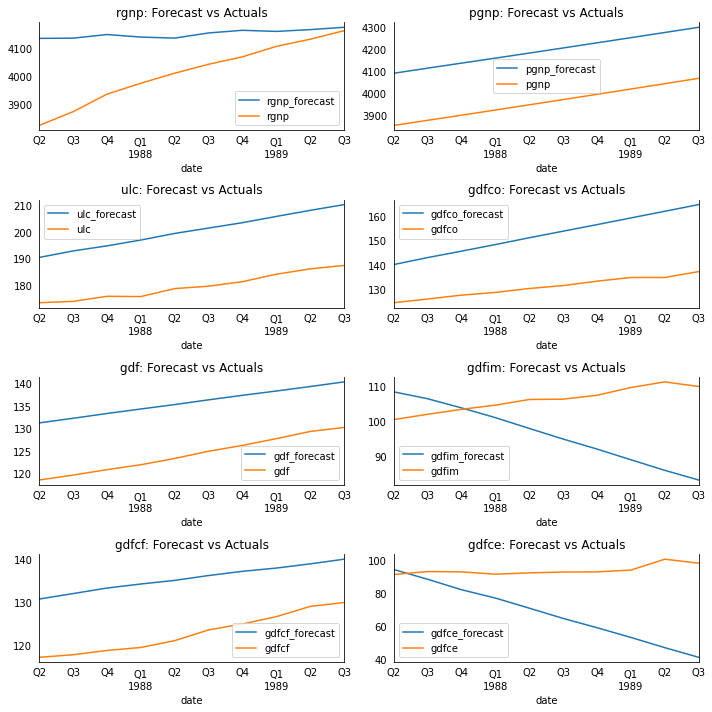

In [71]:
fig, axes = plt.subplots(nrows=int(len(df.columns)/2), ncols=2, figsize=(10,10))
for i, (col,ax) in enumerate(zip(df.columns, axes.flatten())):
    df_results[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    df_test[col][-num_observ:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)

plt.tight_layout();

```
Evaluate the Forecasts
```



In [72]:
from statsmodels.tsa.stattools import acf
def adjust(val, length= 6): return str(val).ljust(length)

def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'corr':corr, 'minmax':minmax})

print('Forecast Accuracy of: rgnp')
accuracy_prod = forecast_accuracy(df_results['rgnp_forecast'].values, df_test['rgnp'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

print('\nForecast Accuracy of: pgnp')
accuracy_prod = forecast_accuracy(df_results['pgnp_forecast'].values, df_test['pgnp'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

print('\nForecast Accuracy of: ulc')
accuracy_prod = forecast_accuracy(df_results['ulc_forecast'].values, df_test['ulc'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

print('\nForecast Accuracy of: gdfco')
accuracy_prod = forecast_accuracy(df_results['gdfco_forecast'].values, df_test['gdfco'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

print('\nForecast Accuracy of: gdf')
accuracy_prod = forecast_accuracy(df_results['gdf_forecast'].values, df_test['gdf'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

print('\nForecast Accuracy of: gdfim')
accuracy_prod = forecast_accuracy(df_results['gdfim_forecast'].values, df_test['gdfim'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

print('\nForecast Accuracy of: gdfcf')
accuracy_prod = forecast_accuracy(df_results['gdfcf_forecast'].values, df_test['gdfcf'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

print('\nForecast Accuracy of: gdfce')
accuracy_prod = forecast_accuracy(df_results['gdfce_forecast'].values, df_test['gdfce'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

Forecast Accuracy of: rgnp
mape   :  0.0352
me     :  138.8378
mae    :  138.8378
mpe    :  0.0352
rmse   :  167.7948
corr   :  0.8791
minmax :  0.0335

Forecast Accuracy of: pgnp
mape   :  0.0593
me     :  234.9074
mae    :  234.9074
mpe    :  0.0593
rmse   :  234.9138
corr   :  1.0
minmax :  0.056

Forecast Accuracy of: ulc
mape   :  0.1153
me     :  20.7382
mae    :  20.7382
mpe    :  0.1153
rmse   :  20.8121
corr   :  0.9879
minmax :  0.1034

Forecast Accuracy of: gdfco
mape   :  0.1635
me     :  21.4885
mae    :  21.4885
mpe    :  0.1635
rmse   :  21.8319
corr   :  0.9959
minmax :  0.1401

Forecast Accuracy of: gdf
mape   :  0.0934
me     :  11.5606
mae    :  11.5606
mpe    :  0.0934
rmse   :  11.603
corr   :  0.9982
minmax :  0.0853

Forecast Accuracy of: gdfim
mape   :  0.1143
me     :  -9.8078
mae    :  12.3404
mpe    :  -0.0892
rmse   :  15.1206
corr   :  -0.9774
minmax :  0.1135

Forecast Accuracy of: gdfcf
mape   :  0.1048
me     :  12.7948
mae    :  12.7948
mpe    :  0.1048

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  


*Section 3 - LSTM Model*

In [73]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? n
Nothing done.


In [74]:
filepath = 'https://raw.githubusercontent.com/selva86/datasets/master/Raotbl6.csv'
df = pd.read_csv(filepath, parse_dates=['date'], index_col='date')

In [75]:
import random

window=2
BATCH_SIZE=1

def create_data_for_lstm(data,window):
    X=[]
    Y=[]
    for i in range(len(data)-window):
        X.append(np.asarray(data[i:i+window]).reshape((window,1)))
        Y.append(data[i+window])
    return np.asarray(X),np.asarray(Y)

X, Y = create_data_for_lstm(np.asarray(df['rgnp']),window)
len_data = len(X)
X_train_val = X[:int(0.9*len_data)]
Y_train_val = Y[:int(0.9*len_data)]
X_test = X[int(0.9*len_data):]
Y_test = Y[int(0.9*len_data):]

data = list(zip(X_train_val,Y_train_val))
random.shuffle(data)
X_train_val,Y_train_val = zip(*data)
X_train_val=np.asarray(list(X_train_val))
Y_train_val=np.asarray(list(Y_train_val))

X_train = X_train_val[:int(0.8*len(X))]
Y_train = Y_train_val[:int(0.8*len(X))]
X_val = X_train_val[int(0.8*len(X)):]
Y_val = Y_train_val[int(0.8*len(X)):]


print(X_train.shape,Y_train.shape)
print(X_val.shape,Y_val.shape)
print(X_test.shape,Y_test.shape)

(96, 2, 1) (96,)
(12, 2, 1) (12,)
(13, 2, 1) (13,)


In [76]:
from torch.utils.data import Dataset, DataLoader, TensorDataset

train_dataset = TensorDataset(torch.from_numpy(X_train).float(),torch.from_numpy(Y_train).float())
val_dataset = TensorDataset(torch.from_numpy(X_val).float(),torch.from_numpy(Y_val).float())
test_dataset = TensorDataset(torch.from_numpy(X_test).float(),torch.from_numpy(Y_test).float())

train_dataloader = DataLoader(train_dataset,batch_size=BATCH_SIZE,shuffle=True)
val_dataloader = DataLoader(val_dataset,batch_size=BATCH_SIZE,shuffle=True)
test_dataloader = DataLoader(test_dataset,batch_size=BATCH_SIZE,shuffle=True)

datatloaders={'train':train_dataloader,'val':val_dataloader,'test':test_dataloader}

In [77]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0, c0))
        out = out[:, -1, :]
        out = self.fc(out)
        

        return out

In [78]:
def count_parameters(model): 
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [79]:
import copy
import os

NUM_EPOCHS=2000


input_dim=1
hidden_dims=[2,4,8,16,32]
layer_dim=2
output_dim=1
history_rgnp={}

for hid_dim in hidden_dims:
    lstm_model = LSTMModel(input_dim,hid_dim,layer_dim,output_dim)
    print('\nHidden dim size: ',hid_dim)
    print('Number of parameters for LSTM model: '+str(count_parameters(lstm_model)))

    criterion = nn.MSELoss()
    optimizer = optim.Adam(lstm_model.parameters())

    best_val_loss=100000000.0
    best_lstm_model=copy.deepcopy(lstm_model)
    dest_path_best_model='LSTM_best_model_hd_'+str(hid_dim)+'.pth'

    history_rgnp[hid_dim]={'train_loss':[],'val_loss':[]}

    num_batches=len(train_dataloader)
    for epoch in range(NUM_EPOCHS):  
        
        for phase in ['train','val']:
            if phase=='train':
                lstm_model.train()
            else:
                lstm_model.eval()
            running_loss = 0.0
            running_acc = 0.0
            samples=0
            for i, data_btch in enumerate(datatloaders[phase]):
                inputs, labels = data_btch
                optimizer.zero_grad()
                outputs = lstm_model(inputs)
                loss = criterion(outputs, labels)

                if phase=='train':
                    loss.backward()
                    optimizer.step()

                samples += labels.size(0)
                running_loss += loss.item()*labels.size(0)
            epoch_loss = float(running_loss)/samples
            history_rgnp[hid_dim][phase+'_loss'].append(epoch_loss)
            if epoch%100==0:
                print('Epoch {}:  {} loss: {}'.format(str(epoch),phase,str(epoch_loss)[:6]))
            if phase=='val':
                if epoch_loss<best_val_loss:
                    best_cnn_val_acc = epoch_loss
                    best_cnn_model = copy.deepcopy(lstm_model)
                    torch.save(lstm_model,dest_path_best_model)
                


Hidden dim size:  2
Number of parameters for LSTM model: 91


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0:  train loss: 724093
Epoch 0:  val loss: 706524
Epoch 100:  train loss: 708916
Epoch 100:  val loss: 691471
Epoch 200:  train loss: 694774
Epoch 200:  val loss: 677458
Epoch 300:  train loss: 680790
Epoch 300:  val loss: 663602
Epoch 400:  train loss: 666964
Epoch 400:  val loss: 649902
Epoch 500:  train loss: 653295
Epoch 500:  val loss: 636362
Epoch 600:  train loss: 639784
Epoch 600:  val loss: 622977
Epoch 700:  train loss: 626429
Epoch 700:  val loss: 609751
Epoch 800:  train loss: 613233
Epoch 800:  val loss: 596682
Epoch 900:  train loss: 600193
Epoch 900:  val loss: 583771
Epoch 1000:  train loss: 587311
Epoch 1000:  val loss: 571015
Epoch 1100:  train loss: 574587
Epoch 1100:  val loss: 558418
Epoch 1200:  train loss: 562018
Epoch 1200:  val loss: 545978
Epoch 1300:  train loss: 549608
Epoch 1300:  val loss: 533694
Epoch 1400:  train loss: 537355
Epoch 1400:  val loss: 521568
Epoch 1500:  train loss: 525258
Epoch 1500:  val loss: 509598
Epoch 1600:  train loss: 513319


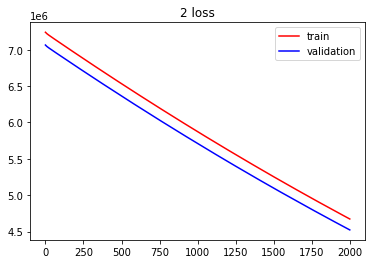

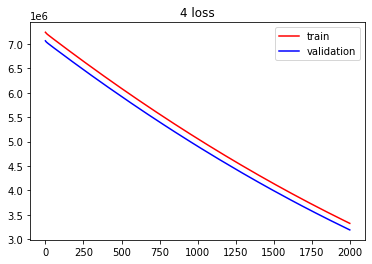

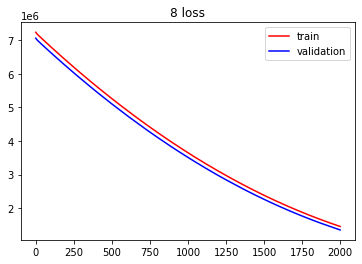

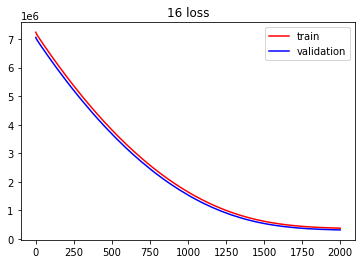

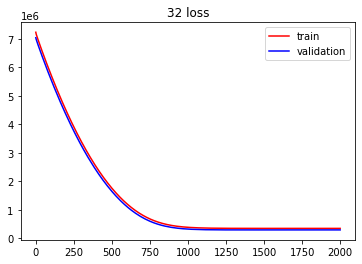

In [80]:
for hid_size,vals in history_rgnp.items():
    plt.plot(vals['train_loss'],c='red')
    plt.plot(vals['val_loss'],c='blue')
    plt.legend(["train", "validation"], loc ="upper right")
    plt.title(str(hid_size)+' loss')
    plt.show()

# Question 4

In [81]:
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#93D30C", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 14, 10
register_matplotlib_converters()

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

4a.

In [82]:
# Initilize satates:

a=np.array([[(math.sqrt(99))/10,-1/10],[1/10,(math.sqrt(99))/10]])
b=np.array([[math.sqrt(2)/2,-2/2],[math.sqrt(2)/2,math.sqrt(2)/2]])

sigma1=0.01
mean1=0
#The noise ϵ1 is i.i.d. and distributed normally with σ2 = 0.01**2
noise1= np.random.normal(loc=mean1, scale=sigma1**2, size=[2,2000])

sigma2=0.2
mean2=0
#The noise ϵ1 is i.i.d. and distributed normally with σ2 = 0.2**2
noise2=np.random.normal(loc=mean2, scale=sigma2**2, size=[2,2000])

#X0 & Y0:
x0=np.array([1,0])+noise1[:,0] #do we need to add noise to XO?
y0=b.dot(x0)+noise2[:,0] #not true- how do w know the real YO?

length=2000
train_size=1000
test_size=1000

In [83]:
x=[x0]
y_hat=[y0]

#Generte 2000 estimations for unobserved state vectors X
for i in range (length-1):
  # X(k+1) = AX(k) + ϵ1(k+1)
  x_next= a.dot(x[i])+noise1[:,i+1]
  x.append(x_next)
  #Y(k+1) = BX(k+1) + ϵ2(k+1)
  y_next=b.dot(x_next)+noise2[:,i+1]
  y_hat.append(y_next)

  #need to update x_hat[i] accordingly
X=pd.DataFrame(x)
y=pd.DataFrame(y_hat)
print(x)

[array([ 1.00004967e+00, -6.75178275e-05]), array([0.99502978, 0.09992334]), array([0.98011457, 0.1988462 ]), array([0.95546937, 0.29583013]), array([0.92107359, 0.38970484]), array([0.87746275, 0.47988011]), array([0.82523433, 0.56522108]), array([0.76465242, 0.64482959]), array([0.69628965, 0.71812851]), array([0.62104086, 0.78425157]), array([0.53945635, 0.84226379]), array([0.45247934, 0.89191125]), array([0.36104433, 0.93261151]), array([0.26578209, 0.96394718]), array([0.16788264, 0.98577649]), array([0.06840724, 0.9976041 ]), array([-0.03179735,  0.99941782]), array([-0.13154832,  0.99102806]), array([-0.23008254,  0.97296917]), array([-0.32636738,  0.94495993]), array([-0.41908087,  0.90759251]), array([-0.50776203,  0.8611628 ]), array([-0.59132637,  0.80620603]), array([-0.66912539,  0.74290135]), array([-0.74011593,  0.67196302]), array([-0.80359126,  0.59460155]), array([-0.85913846,  0.511442  ]), array([-0.90593861,  0.42308841]), array([-0.94376644,  0.33039476]), array(

4.b

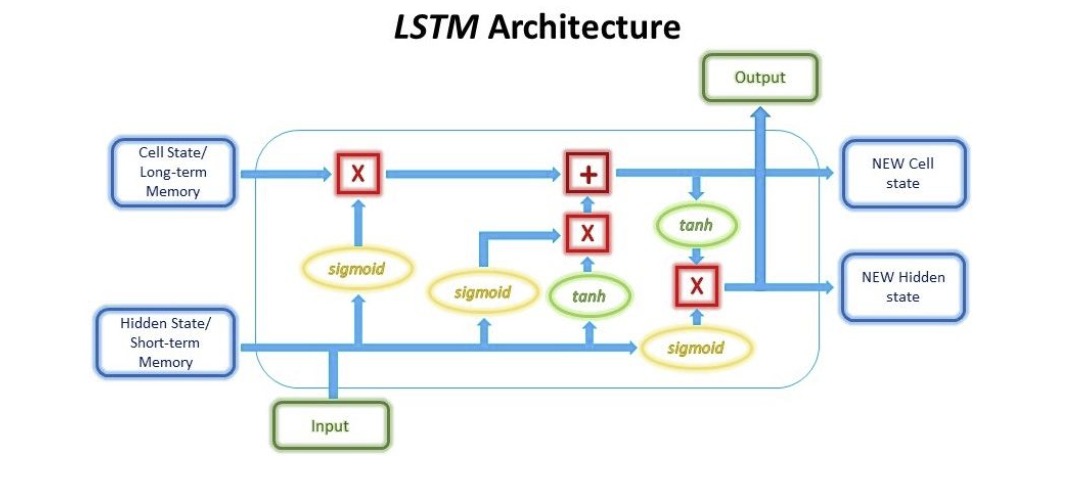

LSTM cells:


*   C*t-1*- Cell state/Long-term memory- (last time stemp output)
*   Hidden-State (Short term memmory)- H*t-1*
*   Input- Y*t-1* (last time stemp output)


INITILAZATIONS:
H0,C0- tensors of Zeroes. in the backpopagation stage the network will learn these states by vy theire deriviations according to the loss functions.

Stages:
1.  Forget gate- Values between 0 to 1=> sigmoid(W *forget* (H*t-1*,Y*t-1*)+BIAS *forget* ) * C*t-1*

2.  Input gate- - Values between -1 to 1==> sigmoid(Wi1(H*t-1*,Y*t-1*)+BIASi1) * tanjh(Wi2(H*t-1*,Y*t-1*)+BIASi2)

>>The outcome represents the information to be kept in the long-term memory and used as the output. As the layer is being trained through back-propagation, the weights in the sigmoid function will be updated such that it learns to only let the useful pass through while discarding the less critical features

3.  1+2: will define our C**t** value (New Long term memmory)

4.  sigmoid(W output1 (H*t-1*,Y*t-1*)+BIAS output1) * tan (W output1(C**t**) + BIAS output2)- will define our output (Y_hat **t**) and out new Hidden state (H_hat **t**)  
>First, the previous short-term memory and current input (H*t-1*,Y*t-1*) will be passed into a sigmoid function (Yes, this is the 3rd time we’re doing this) with different weights yet again to create the third and final filter. Then, we put the new long-term memory (C**t**) through an activation tanh function. The output from these 2 processes will be multiplied to produce the new short-term memory ( H**t**). The short-term ( H**t**) and long-term memory (C**t**) produced by these gates will then be carried over to the next cell for the process to be repeated. The output of each time step can be obtained ( Y**t**) from the short-term memory, also known as the hidden state.

Pre-processing

In [84]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [85]:
from sklearn.model_selection import train_test_split

def train_val_test_split(X, y,val_ratio, test_ratio):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_ratio, shuffle=False)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_ratio, shuffle=False)
    return X_train, X_val, X_test, y_train, y_val, y_test

X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(X ,y,0.2, 0.5)

In [86]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train_arr = scaler.fit_transform(X_train)
X_val_arr = scaler.transform(X_val)
X_test_arr = scaler.transform(X_test)

y_train_arr = scaler.fit_transform(y_train)
y_val_arr = scaler.transform(y_val)
y_test_arr = scaler.transform(y_test)

In [87]:
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim

input_dim = len(X_train.columns)
output_dim = len(y_train.columns)
hidden_dim = 64
layer_dim = 3
dropout = 0.2
n_epochs = 100
learning_rate = 1e-3
weight_decay = 1e-6
batch_size =50

#put the data into tensors
train_features = torch.Tensor(X_train_arr) #torch.Size([800, 2])
train_targets = torch.Tensor(y_train_arr) #torch.Size([800, 2])
val_features = torch.Tensor(X_val_arr)  #torch.Size([200, 2])
val_targets = torch.Tensor(y_val_arr)  #torch.Size([200, 2])
test_features = torch.Tensor(X_test_arr)  #torch.Size([1000, 2])
test_targets = torch.Tensor(y_test_arr)  #torch.Size([1000, 2])
# test_features = torch.Tensor(X_test)  #torch.Size([1000, 2])
# test_targets = torch.Tensor(y_test)  #torch.Size([1000, 2])

train = TensorDataset(train_features, train_targets)
val = TensorDataset(val_features, val_targets)
test = TensorDataset(test_features, test_targets)

#DataLoader wraps an iterable around the Dataset to enable easy access to the samples:
train_loader = DataLoader(train, batch_size=batch_size, shuffle=False, drop_last=True)
val_loader = DataLoader(val, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader_one = DataLoader(test, batch_size=1, shuffle=False, drop_last=True)

## Building a model

We'll encapsulate the complexity of our model into a class that extends from `torch.nn.Module`:

Our Predictor contains 2 methods:

*  constructor - initialize all helper data and create the layers

*  forward - get the sequences, pass all of them through the LSTM layer, at once. We take the output of the last time step and pass it through our linear layer to get the prediction.

In [88]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_prob):
        super(LSTMModel, self).__init__()
        # Defining the number of layers and the nodes in each layer
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        # LSTM layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob)

        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)


    def forward(self, x):
        # Initializing hidden state for first input with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim)
        # h0 = torch(self.layer_dim, x.size(0), self.hidden_dim)

        # Initializing cell state for first input with zeros
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim)

        # One time step
        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        # Forward propagation by passing in the input, hidden state, and cell state into the model
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        #print('hn shape:', hn.shape, 'hn:',hn,'cn shape:', cn.shape, 'cn:',cn )
        print('hn shape:', hn.shape)

        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size) so that it can fit into the fully connected layer
        out = out[:, -1, :]

        # Convert the final state to our desired output shape (hidden_dim, output_dim)
        out = self.fc(out)

        return out   

In [89]:
def get_model(model, model_params):
    models = {
        # "rnn": RNNModel,
        "lstm": LSTMModel#,
        # "gru": GRUModel,
    }
    return models.get(model.lower())(**model_params)

## Training

Let's build a helper function for the training of our model (we'll reuse it later):

Note that the hidden state is reset at the start of each epoch. We don't use batches of data our model sees every example at once. We'll use mean squared error to measure our training and test error. We'll record both. 

Let's create an instance of our model and train it:

In [90]:
class Optimization:
    def __init__(self, model, loss_fn, optimizer):
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.train_losses = []
        self.val_losses = []
   
    def train_step(self, x, y): #for single batch
        # Sets model to train mode
        self.model.train()

        # Makes predictions per batch (x is the batch)
        yhat = self.model(x)
        # Computes loss
        loss = self.loss_fn(y, yhat)
        # print("y",y, "Yhat",yhat,"Loss",loss)

        # Computes gradients
        loss.backward()

        # Updates parameters and zeroes gradients
        self.optimizer.step()
        self.optimizer.zero_grad()

        # Returns the loss
        return loss.item()


    def train(self, train_loader, val_loader, batch_size=10, n_epochs=50, n_features=2):
            # model_path = f'models/{self.model}_{datetime.now().strftime("%Y-%m-%d %H:%M:%S")}'
            model_path =r'C:\Users\verthaim\OneDrive - HP Inc\Data Science M.Sc- Hadar Verthaim\Hadar\Courses\Deep Learning- Tel Aviv University'

            for epoch in range(1, n_epochs + 1):   

              #for train set:
                batch_losses = []                      
                for x_batch, y_batch in train_loader:
                    x_batch = x_batch.view([batch_size, -1, n_features]).to(device)
                    y_batch = y_batch.to(device)
                    loss = self.train_step(x_batch, y_batch)
                    batch_losses.append(loss)
                training_loss = np.mean(batch_losses)
                print ('batch_loses_size',len(batch_losses))
                self.train_losses.append(training_loss)

              #for val: torch.no_grad() means that we dont want to calculate gradient for the backpropagation- because it's validation/test set and not train set  
                with torch.no_grad(): 
                    batch_val_losses = []
                    for x_val, y_val in val_loader:
                        x_val = x_val.view([batch_size, -1, n_features]).to(device)
                        y_val = y_val.to(device)
                        self.model.eval()
                        yhat = self.model(x_val)
                        val_loss = self.loss_fn(y_val, yhat).item()
                        batch_val_losses.append(val_loss)
                    validation_loss = np.mean(batch_val_losses)
                    self.val_losses.append(validation_loss)

                if (epoch <= 10) | (epoch % 50 == 0):
                    print(f"[{epoch}/{n_epochs}] Training loss: {training_loss:.4f}\t Validation loss: {validation_loss:.4f}")

            torch.save(self.model.state_dict(), model_path)
    
    def plot_losses(self):
          plt.plot(self.train_losses, label="Training loss")
          plt.plot(self.val_losses, label="Validation loss")
          plt.legend()
          plt.title("Losses")
          plt.show()
          plt.close()

    def evaluate(self, test_loader, batch_size=1, n_features=2):
      with torch.no_grad(): #torch.no_grad() means that we dont want to calculate gradient for the backpropagation- because it's validation/test set and not train set
          predictions = []
          values = []
          test_error = []

          for x_test, y_test in test_loader:
              x_test = x_test.view([batch_size, -1, n_features]).to(device)
              y_test = y_test.to(device)
              self.model.eval()
              yhat = self.model(x_test)
              predictions.append(yhat.to(device).detach().numpy())
              values.append(y_test.to(device).detach().numpy())
              error = self.loss_fn(y_test, yhat).item()
              test_error.append(error)
          mean_error = np.mean(test_error)
          # self.error.append(mean_error)

      return predictions, values,test_error

# Prodeict Y

hn shape: torch.Size([3, 50, 64])
hn shape: torch.Size([3, 50, 64])
hn shape: torch.Size([3, 50, 64])
hn shape: torch.Size([3, 50, 64])
hn shape: torch.Size([3, 50, 64])
hn shape: torch.Size([3, 50, 64])
hn shape: torch.Size([3, 50, 64])
hn shape: torch.Size([3, 50, 64])
hn shape: torch.Size([3, 50, 64])
hn shape: torch.Size([3, 50, 64])
hn shape: torch.Size([3, 50, 64])
hn shape: torch.Size([3, 50, 64])
hn shape: torch.Size([3, 50, 64])
hn shape: torch.Size([3, 50, 64])
hn shape: torch.Size([3, 50, 64])
hn shape: torch.Size([3, 50, 64])
batch_loses_size 16
hn shape: torch.Size([3, 50, 64])
hn shape: torch.Size([3, 50, 64])
hn shape: torch.Size([3, 50, 64])
hn shape: torch.Size([3, 50, 64])
[1/100] Training loss: 0.2901	 Validation loss: 0.2688
hn shape: torch.Size([3, 50, 64])
hn shape: torch.Size([3, 50, 64])
hn shape: torch.Size([3, 50, 64])
hn shape: torch.Size([3, 50, 64])
hn shape: torch.Size([3, 50, 64])
hn shape: torch.Size([3, 50, 64])
hn shape: torch.Size([3, 50, 64])
hn shap

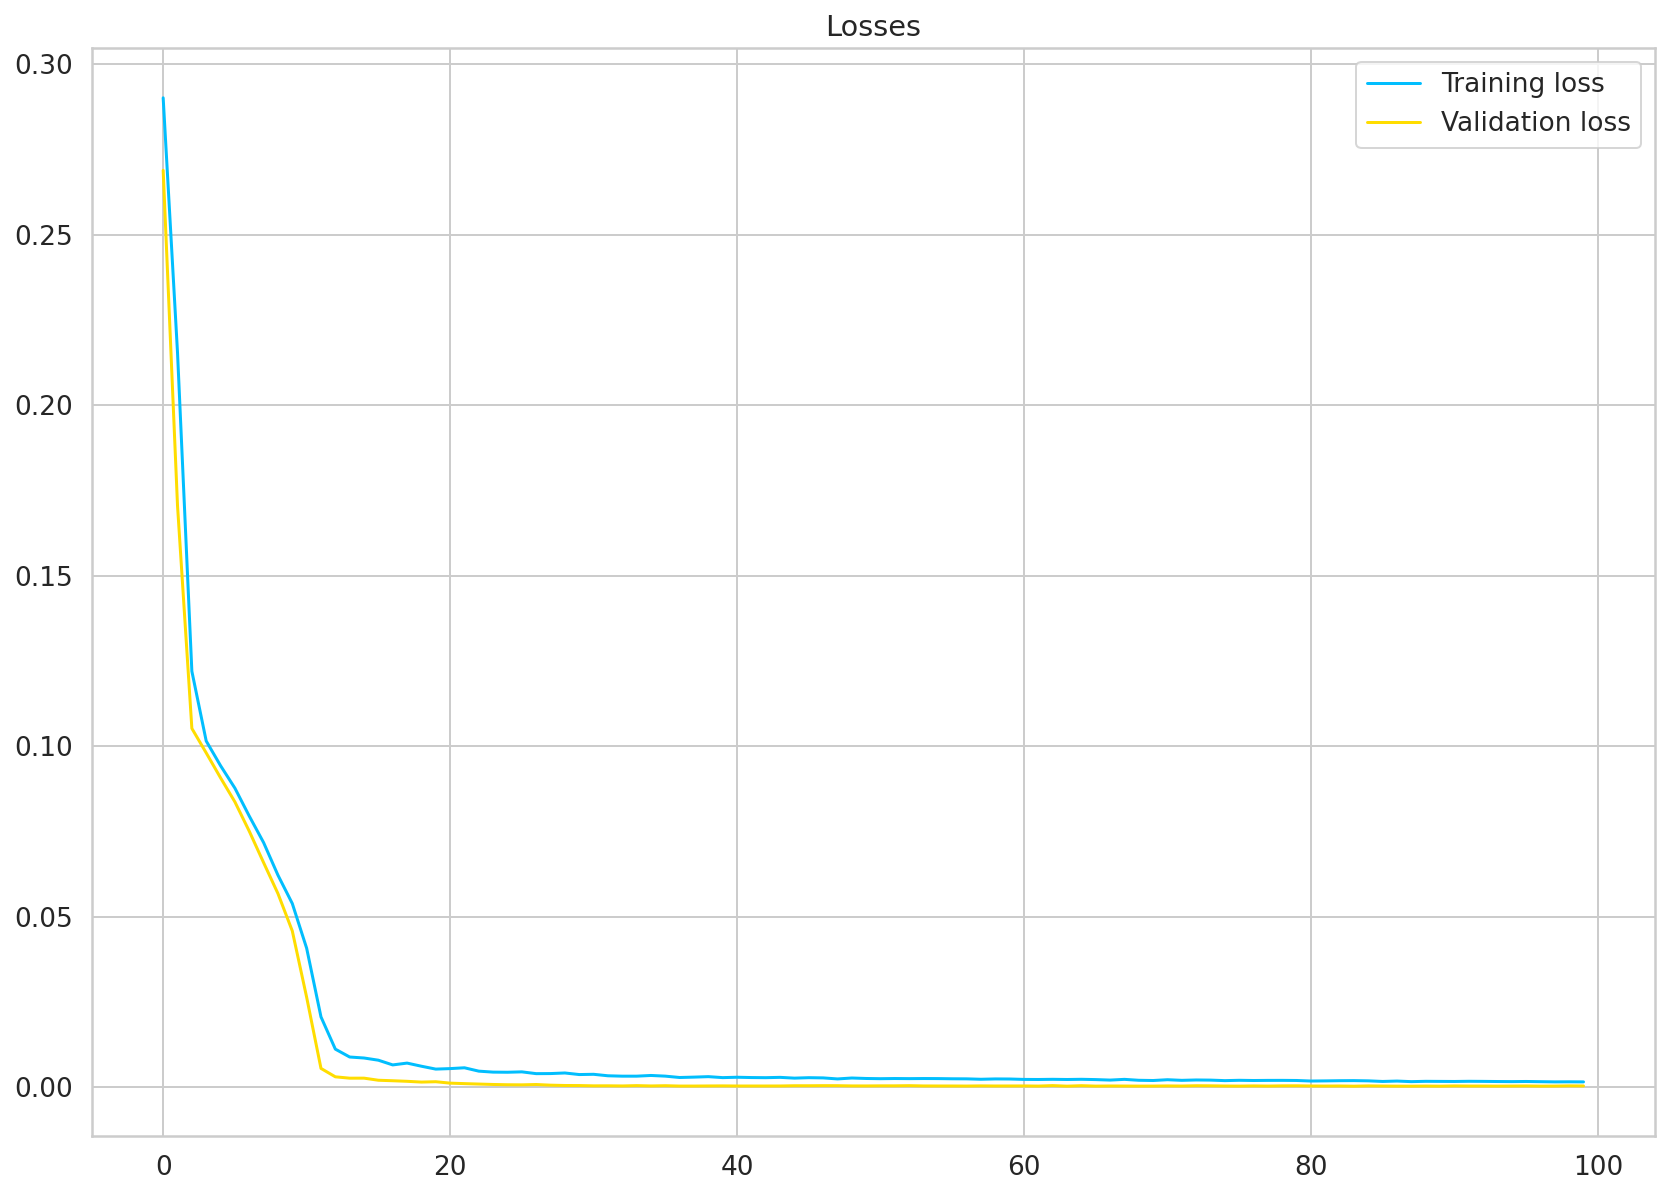

In [91]:
model_params = {'input_dim': input_dim,
                'hidden_dim' : hidden_dim,
                'layer_dim' : layer_dim,
                'output_dim' : output_dim,
                'dropout_prob' : dropout}

model = get_model('lstm', model_params)

loss_fn = nn.MSELoss(reduction="mean")
optimizer = optim.Adam(model.parameters(), lr=learning_rate,weight_decay=weight_decay) 

opt = Optimization(model=model, loss_fn=loss_fn, optimizer=optimizer)
opt.train(train_loader, val_loader, batch_size=batch_size, n_epochs=n_epochs, n_features=input_dim)
opt.plot_losses()

In [92]:
predictions, values, error = opt.evaluate(test_loader_one, batch_size=1, n_features=input_dim)
preds = np.concatenate(predictions, axis=0)
vals = np.concatenate(values, axis=0)

hn shape: torch.Size([3, 1, 64])
hn shape: torch.Size([3, 1, 64])
hn shape: torch.Size([3, 1, 64])
hn shape: torch.Size([3, 1, 64])
hn shape: torch.Size([3, 1, 64])
hn shape: torch.Size([3, 1, 64])
hn shape: torch.Size([3, 1, 64])
hn shape: torch.Size([3, 1, 64])
hn shape: torch.Size([3, 1, 64])
hn shape: torch.Size([3, 1, 64])
hn shape: torch.Size([3, 1, 64])
hn shape: torch.Size([3, 1, 64])
hn shape: torch.Size([3, 1, 64])
hn shape: torch.Size([3, 1, 64])
hn shape: torch.Size([3, 1, 64])
hn shape: torch.Size([3, 1, 64])
hn shape: torch.Size([3, 1, 64])
hn shape: torch.Size([3, 1, 64])
hn shape: torch.Size([3, 1, 64])
hn shape: torch.Size([3, 1, 64])
hn shape: torch.Size([3, 1, 64])
hn shape: torch.Size([3, 1, 64])
hn shape: torch.Size([3, 1, 64])
hn shape: torch.Size([3, 1, 64])
hn shape: torch.Size([3, 1, 64])
hn shape: torch.Size([3, 1, 64])
hn shape: torch.Size([3, 1, 64])
hn shape: torch.Size([3, 1, 64])
hn shape: torch.Size([3, 1, 64])
hn shape: torch.Size([3, 1, 64])
hn shape: 

In [93]:
error=pd.Series(error)
error.abs().mean()

0.0004141669879811616

In [94]:
#Results dataFrame:
predictions=pd.DataFrame(preds)
predictions.rename(columns={0: 'y1_predicted', 1: 'y2_predicted'}, inplace=True)
values=pd.DataFrame(vals)
values.rename(columns={0: 'y1', 1: 'y2'}, inplace=True)

results = pd.concat([values, predictions], axis=1)


x_test_arr=pd.DataFrame(X_test_arr)
x_test_arr.rename(columns={0: 'X1', 1: 'X2'}, inplace=True)

frames = [x_test_arr,results] 
df_result = pd.concat(frames, axis=1)

In [95]:
results

,y1,y2,y1_predicted,y2_predicted
0,0.887102,0.707040,0.903969,0.701552
1,0.858501,0.701009,0.876259,0.739820
2,0.806145,0.784899,0.844735,0.775573
3,0.793361,0.803397,0.809611,0.808622
4,0.771548,0.853326,0.771367,0.838635
...,...,...,...,...
995,0.961496,0.350119,0.961473,0.323484
996,0.986870,0.358217,0.972511,0.365936
997,0.956199,0.381029,0.978981,0.410121
998,0.982837,0.471603,0.980782,0.455500


In [96]:
df_result

,X1,X2,y1,y2,y1_predicted,y2_predicted
0,0.967810,0.323015,0.887102,0.707040,0.903969,0.701552
1,0.983227,0.370623,0.858501,0.701009,0.876259,0.739820
2,0.993762,0.419556,0.806145,0.784899,0.844735,0.775573
3,0.999315,0.469413,0.793361,0.803397,0.809611,0.808622
4,0.999921,0.519508,0.771548,0.853326,0.771367,0.838635
...,...,...,...,...,...,...
995,0.670488,0.027668,0.961496,0.350119,0.961473,0.323484
996,0.716887,0.046968,0.986870,0.358217,0.972511,0.365936
997,0.761080,0.070898,0.956199,0.381029,0.978981,0.410121
998,0.802695,0.099225,0.982837,0.471603,0.980782,0.455500


In [97]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def calculate_metrics(df):
    return {'mae' : mean_absolute_error(vals, preds),
            'rmse' : mean_squared_error(vals, preds) ** 0.5,
            'r2' : r2_score(vals, preds)}

result_metrics = calculate_metrics(df_result)
result_metrics

{'mae': 0.01613763, 'r2': 0.9961530520651052, 'rmse': 0.02035109565299171}

#Predict X
Change X to be target and Y to be features

In [98]:
#put the data into tensors
train_features = torch.Tensor(y_train_arr) #torch.Size([800, 2])
train_targets = torch.Tensor(X_train_arr) #torch.Size([800, 2])
val_features = torch.Tensor(y_val_arr)  #torch.Size([200, 2])
val_targets = torch.Tensor(X_val_arr)  #torch.Size([200, 2])
test_features = torch.Tensor(y_test_arr)  #torch.Size([1000, 2])
test_targets = torch.Tensor(X_test_arr)  #torch.Size([1000, 2])

train = TensorDataset(train_features, train_targets)
val = TensorDataset(val_features, val_targets)
test = TensorDataset(test_features, test_targets)

#DataLoader wraps an iterable around the Dataset to enable easy access to the samples:
train_loader = DataLoader(train, batch_size=batch_size, shuffle=False, drop_last=True)
val_loader = DataLoader(val, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader_one = DataLoader(test, batch_size=1, shuffle=False, drop_last=True)

hn shape: torch.Size([3, 50, 64])
hn shape: torch.Size([3, 50, 64])
hn shape: torch.Size([3, 50, 64])
hn shape: torch.Size([3, 50, 64])
hn shape: torch.Size([3, 50, 64])
hn shape: torch.Size([3, 50, 64])
hn shape: torch.Size([3, 50, 64])
hn shape: torch.Size([3, 50, 64])
hn shape: torch.Size([3, 50, 64])
hn shape: torch.Size([3, 50, 64])
hn shape: torch.Size([3, 50, 64])
hn shape: torch.Size([3, 50, 64])
hn shape: torch.Size([3, 50, 64])
hn shape: torch.Size([3, 50, 64])
hn shape: torch.Size([3, 50, 64])
hn shape: torch.Size([3, 50, 64])
batch_loses_size 16
hn shape: torch.Size([3, 50, 64])
hn shape: torch.Size([3, 50, 64])
hn shape: torch.Size([3, 50, 64])
hn shape: torch.Size([3, 50, 64])
[1/100] Training loss: 0.2913	 Validation loss: 0.2473
hn shape: torch.Size([3, 50, 64])
hn shape: torch.Size([3, 50, 64])
hn shape: torch.Size([3, 50, 64])
hn shape: torch.Size([3, 50, 64])
hn shape: torch.Size([3, 50, 64])
hn shape: torch.Size([3, 50, 64])
hn shape: torch.Size([3, 50, 64])
hn shap

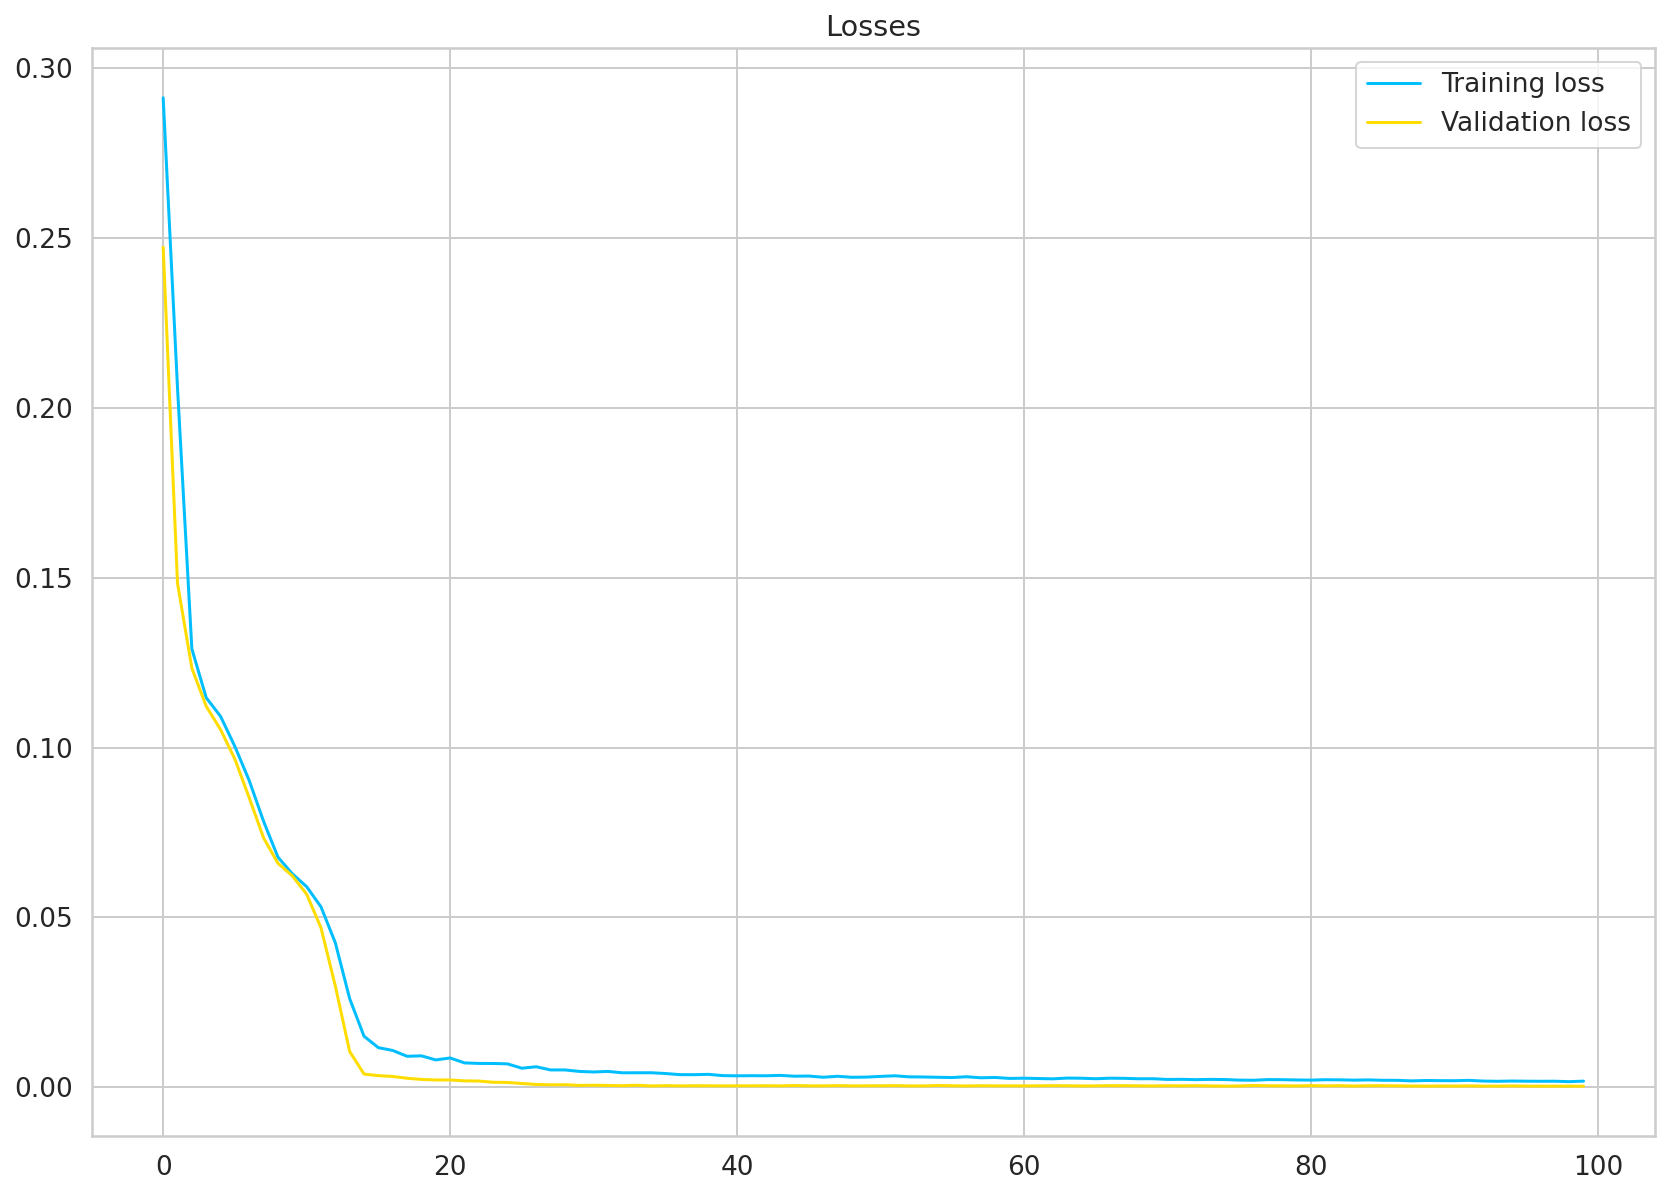

In [99]:
model_params = {'input_dim': input_dim,
                'hidden_dim' : hidden_dim,
                'layer_dim' : layer_dim,
                'output_dim' : output_dim,
                'dropout_prob' : dropout}

model = get_model('lstm', model_params)

loss_fn = nn.MSELoss(reduction="mean")
optimizer = optim.Adam(model.parameters(), lr=learning_rate,weight_decay=weight_decay) 
opt = Optimization(model=model, loss_fn=loss_fn, optimizer=optimizer)
opt.train(train_loader, val_loader, batch_size=batch_size, n_epochs=n_epochs, n_features=input_dim)
opt.plot_losses()

In [100]:
predictions, values, error = opt.evaluate(test_loader_one, batch_size=1, n_features=input_dim)
preds = np.concatenate(predictions, axis=0)
vals = np.concatenate(values, axis=0)

hn shape: torch.Size([3, 1, 64])
hn shape: torch.Size([3, 1, 64])
hn shape: torch.Size([3, 1, 64])
hn shape: torch.Size([3, 1, 64])
hn shape: torch.Size([3, 1, 64])
hn shape: torch.Size([3, 1, 64])
hn shape: torch.Size([3, 1, 64])
hn shape: torch.Size([3, 1, 64])
hn shape: torch.Size([3, 1, 64])
hn shape: torch.Size([3, 1, 64])
hn shape: torch.Size([3, 1, 64])
hn shape: torch.Size([3, 1, 64])
hn shape: torch.Size([3, 1, 64])
hn shape: torch.Size([3, 1, 64])
hn shape: torch.Size([3, 1, 64])
hn shape: torch.Size([3, 1, 64])
hn shape: torch.Size([3, 1, 64])
hn shape: torch.Size([3, 1, 64])
hn shape: torch.Size([3, 1, 64])
hn shape: torch.Size([3, 1, 64])
hn shape: torch.Size([3, 1, 64])
hn shape: torch.Size([3, 1, 64])
hn shape: torch.Size([3, 1, 64])
hn shape: torch.Size([3, 1, 64])
hn shape: torch.Size([3, 1, 64])
hn shape: torch.Size([3, 1, 64])
hn shape: torch.Size([3, 1, 64])
hn shape: torch.Size([3, 1, 64])
hn shape: torch.Size([3, 1, 64])
hn shape: torch.Size([3, 1, 64])
hn shape: 

In [101]:
#Results dataFrame:
predictions=pd.DataFrame(preds)
predictions.rename(columns={0: 'X1_predicted', 1: 'X2_predicted'}, inplace=True)
values=pd.DataFrame(vals)
values.rename(columns={0: 'X1', 1: 'X2'}, inplace=True)

results = pd.concat([values, predictions], axis=1)

y_test_arr=pd.DataFrame(y_test_arr)
y_test_arr.rename(columns={0: 'y1', 1: 'y2'}, inplace=True)

frames = [y_test_arr,results] 
df_result_x = pd.concat(frames, axis=1)

In [102]:
df_result

,X1,X2,y1,y2,y1_predicted,y2_predicted
0,0.967810,0.323015,0.887102,0.707040,0.903969,0.701552
1,0.983227,0.370623,0.858501,0.701009,0.876259,0.739820
2,0.993762,0.419556,0.806145,0.784899,0.844735,0.775573
3,0.999315,0.469413,0.793361,0.803397,0.809611,0.808622
4,0.999921,0.519508,0.771548,0.853326,0.771367,0.838635
...,...,...,...,...,...,...
995,0.670488,0.027668,0.961496,0.350119,0.961473,0.323484
996,0.716887,0.046968,0.986870,0.358217,0.972511,0.365936
997,0.761080,0.070898,0.956199,0.381029,0.978981,0.410121
998,0.802695,0.099225,0.982837,0.471603,0.980782,0.455500


In [103]:
df_result_x

,y1,y2,X1,X2,X1_predicted,X2_predicted
0,0.887102,0.707040,0.967810,0.323015,0.975302,0.335623
1,0.858501,0.701009,0.983227,0.370623,0.968780,0.352336
2,0.806145,0.784899,0.993762,0.419556,0.996665,0.449187
3,0.793361,0.803397,0.999315,0.469413,1.000749,0.471329
4,0.771548,0.853326,0.999921,0.519508,1.011095,0.519675
...,...,...,...,...,...,...
995,0.961496,0.350119,0.670488,0.027668,0.717755,0.057311
996,0.986870,0.358217,0.716887,0.046968,0.732620,0.050145
997,0.956199,0.381029,0.761080,0.070898,0.745655,0.078014
998,0.982837,0.471603,0.802695,0.099225,0.831003,0.119950


In [104]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def calculate_metrics(df):
    return {'mae' : mean_absolute_error(vals, preds),
            'rmse' : mean_squared_error(vals, preds) ** 0.5,
            'r2' : r2_score(vals, preds)}

result_metrics = calculate_metrics(df_result_x)
result_metrics

{'mae': 0.013291851, 'r2': 0.9976788638705194, 'rmse': 0.017056197867406864}